 ## Loading dataset

In [2]:
import os
import pandas as pd

base_dir = base_dir = r"C:\Users\nandh\Downloads\archive\Geolife Trajectories 1.3\Data"

for user_id in os.listdir(base_dir):
    user_path = os.path.join(base_dir, user_id, 'Trajectory')
    for file_name in os.listdir(user_path):
        if file_name.endswith('.plt'):
            file_path = os.path.join(user_path, file_name)
            df = pd.read_csv(file_path, skiprows=6, header=None)
            print(df.head())  # Show first trajectory
            break  # remove break to process all files
    break  # remove break to process all users


           0           1  2    3             4           5         6
0  39.984702  116.318417  0  492  39744.120185  2008-10-23  02:53:04
1  39.984683  116.318450  0  492  39744.120255  2008-10-23  02:53:10
2  39.984686  116.318417  0  492  39744.120313  2008-10-23  02:53:15
3  39.984688  116.318385  0  492  39744.120370  2008-10-23  02:53:20
4  39.984655  116.318263  0  492  39744.120428  2008-10-23  02:53:25


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## Reading Geolife Trajectory Files

In [5]:
def read_geolife_trajectory(file_path):
    df = pd.read_csv(file_path, skiprows=6, header=None)
    df.columns = ['lat', 'lon', 'zero', 'altitude', 'date', 'time', 'unused']
    try:
        df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
    except:
        df['datetime'] = pd.to_datetime(df['time'].astype(str))
    return df[['lat', 'lon', 'datetime']]

In [ ]:
base_dir = base_dir = r"C:\Users\nandh\Downloads\archive\Geolife Trajectories 1.3\Data"
trajectories = []

for user_id in os.listdir(base_dir)[:5]:  # Limit to 5 users
    traj_dir = os.path.join(base_dir, user_id, 'Trajectory')
    for file in os.listdir(traj_dir)[:3]:  # First 3 files
        file_path = os.path.join(traj_dir, file)
        try:
            df = read_geolife_trajectory(file_path)
            if len(df) >= 20:
                trajectories.append(df[['lat', 'lon']])
        except Exception as e:
            print("Error:", e)


## preprocessing


In [8]:
scaler = MinMaxScaler()
sequence_length = 10
X, y = [], []

for traj in trajectories:
    coords = traj[['lat', 'lon']].values
    coords = scaler.fit_transform(coords)
    for i in range(len(coords) - sequence_length):
        X.append(coords[i:i+sequence_length])
        y.append(coords[i+sequence_length])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 10, 2)
print("y shape:", y.shape)  # (samples, 2)


X shape: (26268, 10, 2)
y shape: (26268, 2)


## Building and Training the LSTM Model


In [10]:
model = Sequential([
    LSTM(64, input_shape=(sequence_length, 2)),
    Dense(2)  # Output lat, lon
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


C:\Users\nandh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0192 - val_loss: 0.0011
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.8945e-04 - val_loss: 9.2649e-04
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.6645e-04 - val_loss: 7.8709e-04
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.4078e-04 - val_loss: 6.6242e-04
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8163e-04 - val_loss: 4.4788e-04
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5860e-04 - val_loss: 3.6760e-04
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2908e-04 - val_loss: 2.7937e-04
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2616e-04 - val_loss: 3.0377e-04
Epoch 9/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1043e-04 - val_loss: 2.6095e-04
Epoch 10/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1697e-04 - val_loss: 2.0364e-04
Epoch 11/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0442e-04 - val_

## Visualization

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


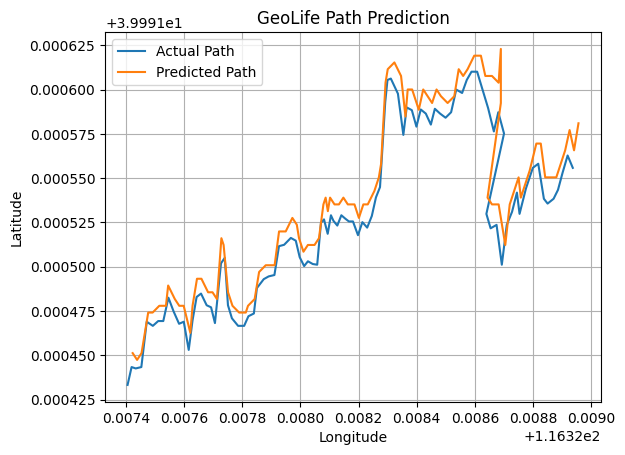

In [12]:
y_pred = model.predict(X[:100])
y_true = y[:100]

# Reverse scaling
y_pred_orig = scaler.inverse_transform(y_pred)
y_true_orig = scaler.inverse_transform(y_true)

plt.plot(y_true_orig[:, 1], y_true_orig[:, 0], label='Actual Path')
plt.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], label='Predicted Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('GeoLife Path Prediction')
plt.grid()
plt.show()


In [13]:
recent_path = trajectories[0][['lat', 'lon']].values[:10]  # First 10 points of a trajectory


In [14]:
recent_scaled = scaler.transform(recent_path)  # Shape: (10, 2)


In [15]:
# Reshape to match model input: (1 sample, 10 steps, 2 features)
recent_scaled = recent_scaled.reshape(1, 10, 2)

# Predict the next point
predicted_scaled = model.predict(recent_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [16]:
predicted_point = scaler.inverse_transform(predicted_scaled)
predicted_lat, predicted_lon = predicted_point[0]
print("Predicted Next Location:")
print("Latitude:", predicted_lat)
print("Longitude:", predicted_lon)


Predicted Next Location:
Latitude: 39.985302
Longitude: 116.319115


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- MAE ---
mae_lat = mean_absolute_error(y_true_orig[:, 0], y_pred_orig[:, 0])  # Latitude
mae_lon = mean_absolute_error(y_true_orig[:, 1], y_pred_orig[:, 1])  # Longitude

print(f"Mean Absolute Error (Latitude): {mae_lat}")
print(f"Mean Absolute Error (Longitude): {mae_lon}")

# --- MSE ---
mse_lat = mean_squared_error(y_true_orig[:, 0], y_pred_orig[:, 0])
mse_lon = mean_squared_error(y_true_orig[:, 1], y_pred_orig[:, 1])

print(f"Mean Squared Error (Latitude): {mse_lat}")
print(f"Mean Squared Error (Longitude): {mse_lon}")

# --- RMSE ---
rmse_lat = np.sqrt(mse_lat)
rmse_lon = np.sqrt(mse_lon)

print(f"Root Mean Squared Error (Latitude): {rmse_lat}")
print(f"Root Mean Squared Error (Longitude): {rmse_lon}")


Mean Absolute Error (Latitude): 1.3829858140823603e-05
Mean Absolute Error (Longitude): 2.1552654103658142e-05
Mean Squared Error (Latitude): 2.907501611599057e-10
Mean Squared Error (Longitude): 5.145355096023256e-10
Root Mean Squared Error (Latitude): 1.705139763069015e-05
Root Mean Squared Error (Longitude): 2.2683375181007026e-05


In [18]:
from geopy.distance import geodesic
import numpy as np

# Calculate geodesic distances
distances = [
    geodesic((lat_true, lon_true), (lat_pred, lon_pred)).meters
    for (lat_true, lon_true, lat_pred, lon_pred) in zip(
        y_true_orig[:, 0], y_true_orig[:, 1],
        y_pred_orig[:, 0], y_pred_orig[:, 1]
    )
]

# Define a threshold (e.g., 100 meters)
threshold = 100

# Convert distances to binary predictions: 1 = correct (TP), 0 = incorrect (FP or FN)
y_pred_binary = np.array(distances) <= threshold
y_true_binary = np.ones_like(y_pred_binary)  # We expected all points to be predicted

# Compute precision, recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Precision (within {threshold} meters): {precision:.2f}")
print(f"Recall (within {threshold} meters): {recall:.2f}")
print(f"F1-Score (within {threshold} meters): {f1:.2f}")


Precision (within 100 meters): 1.00
Recall (within 100 meters): 1.00
F1-Score (within 100 meters): 1.00


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train, epochs=10)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_true_orig = scaler.inverse_transform(y_test)


Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.2487e-04
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0830e-04
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.2625e-05
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.7246e-05
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.3705e-05
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.1192e-05
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.6809e-05
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.2341e-05
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.9311e-05
Epoch 10/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.1424e-05
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
from geopy.distance import geodesic
import numpy as np

# Compute geodesic distances between each predicted and true point
distances = [
    geodesic((lat_true, lon_true), (lat_pred, lon_pred)).meters
    for (lat_true, lon_true, lat_pred, lon_pred) in zip(
        y_true_orig[:, 0], y_true_orig[:, 1],
        y_pred_orig[:, 0], y_pred_orig[:, 1]
    )
]

# Define tolerance in meters (e.g., 100 meters)
tolerance = 100

# Compute percentage of predictions within the tolerance
within_tolerance = np.sum(np.array(distances) <= tolerance) / len(distances)
accuracy_percent = within_tolerance * 100

print(f"Accuracy within {tolerance} meters: {accuracy_percent:.2f}%")



Accuracy within 100 meters: 99.94%


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Time-series data: avoid shuffling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 2)).reshape(-1, 10, 2)  # Scale only training data
X_test = scaler.transform(X_test.reshape(-1, 2)).reshape(-1, 10, 2)  # Use same scaler on test data

In [27]:
from haversine import haversine

# Define threshold (in meters)
threshold = 5  # Adjust based on your use case

# Calculate Haversine distances
haversine_errors = [
    haversine((true_lat, true_lon), (pred_lat, pred_lon), unit='m')
    for (true_lat, true_lon), (pred_lat, pred_lon) in zip(y_true_orig, y_pred_orig)
]

# Percentage of predictions within threshold
accuracy_percentage = (np.array(haversine_errors) <= threshold).mean() * 100
print(f"Accuracy (within {threshold} meters): {accuracy_percentage:.2f}%")

Accuracy (within 5 meters): 85.12%


In [28]:
# Calculate range of latitude/longitude in the dataset
lat_range = np.ptp(trajectories[0]['lat'])  # Peak-to-peak range
lon_range = np.ptp(trajectories[0]['lon'])

# Average relative error (in %)
avg_relative_error_lat = (mae_lat / lat_range) * 100
avg_relative_error_lon = (mae_lon / lon_range) * 100
print(f"Relative Error (Latitude): {avg_relative_error_lat:.2f}%")
print(f"Relative Error (Longitude): {avg_relative_error_lon:.2f}%")


Relative Error (Latitude): 0.05%
Relative Error (Longitude): 0.05%


In [32]:
# 1. Calculate Haversine accuracy
thresholds = [5, 10, 20]  # Meters
for thresh in thresholds:
    accuracy = (np.array(haversine_errors) <= thresh).mean() * 100
    print(f"Accuracy (within {thresh}m): {accuracy:.1f}%")


Accuracy (within 5m): 85.1%
Accuracy (within 10m): 95.2%
Accuracy (within 20m): 98.2%
